# **Fintuning gemma_2b_en for simplified Chinese**

Import neccessary package

导入需要的库


In [1]:
!conda create -n myenv python=3.9 -y
!conda activate myenv
!pip install "tensorflow[and-cuda]"
!pip install -U keras
!pip install -U keras-nlp
!pip install tensorrt

warning  libmamba Cache file "/opt/conda/pkgs/cache/c7b05ae9.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/758dc0ed.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/eab6ca9b.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/6d94291a.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/3864cda3.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/47534735.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/88ec62ec.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/eb045dd1.json" was modified by another program
[+] 0.0s
[+] 0.1s
nodefaults/linux-64 (check zst) ━━━━━━━━━━━━━╸━━━━━━━━━━━   0.0 B Checking  0.1s
nodefaults/noarch (check zst)   ━━━━━━━━━━━━━━╸━━━━━━━━━━   0.0 B Checking  0.1s
nvidia/linux-64 (check zst) 

Import metric using rouge 

导入评估所需库使用rouge指标

In [2]:
!pip install rouge-score
!pip install rouge-chinese

  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9e7e7c9d8df2e7e7711c6e17b2549fbb84e580e1e26ce5ae24018934cff35dae
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


The code is evaluated using rouge metrics, including rouge1 and rougeL metrics.

**ROUGE-1 (Rouge-1)**

ROUGE-1 is a special case of ROUGE-N, focusing on the recall rate of 1-gram (single word). It calculates the ratio of the number of 1-grams shared between the automatically generated abstracts (candidate abstracts) and the reference abstracts to the total number of 1-grams in the reference abstracts. To be specific:

* Molecule: The number of 1-grams that appear in both candidate abstracts and reference abstracts.
* Denominator: The number of 1-grams of the reference summary. The formula for calculating ROUGE-1 can be expressed as: ROUGE-1 = Count Match/Reference Count

Where, Count Match is the maximum number of 1-grams shared by the candidate digest and the Reference digest, and Reference Count is the total number of 1-grams in the reference digest. ROUGE-1 intuitively and concisely reflects word order, and is suitable for short summary evaluation and multi-document summary (without stopping word conditions).

**ROUGE-L (Rouge-L)**

ROUGE-L is an evaluation metric based on the Longest Common Subsequence (LCS). It calculates the length of the longest common subsequence between the automatically generated summary and the reference summary and measures the similarity between the two. To be specific:

* LCS(X, Y) : The length of the longest common subsequence of X and Y.
* m, n: indicates the length of the reference summary and the automatic summary, respectively (generally the number of words included).
* Rlcs, Plcs: Recall rate and accuracy, respectively.
* Flcs: ROUGE-L is an F-measure of recall rate and accuracy.

* The calculation formula of ROUGE-L can be expressed as: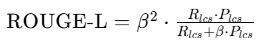

Among them, beta is a parameter used to balance recall rates and accuracy, usually set to a larger number, so that ROUGE-L considers almost only recall rates. This is in contrast to the general evaluation method that only considers the recall rate.

评估代码，使用的是rouge指标，包括rouge1和rougeL指标。

**ROUGE-1 (Rouge-1)**

ROUGE-1是ROUGE-N的一个特例，专注于1-gram（单个词）的召回率。它计算的是自动生成的摘要（候选摘要）与参考摘要之间共有的1-gram的数量与参考摘要中1-gram总数的比例。具体来说：

* 分子：候选摘要和参考摘要都出现的1-gram的个数。
* 分母：参考摘要的1-gram个数。ROUGE-1的计算公式可以表示为：ROUGE-1 = Count Match / Reference Count

其中，Count Match是候选摘要和参考摘要共有的1-gram的最大数量，Reference Count是参考摘要中1-gram的总数量。ROUGE-1能够直观、简洁地反映词序，适用于短摘要评估和多文档摘要（去停用词条件）。

**ROUGE-L (Rouge-L)**

ROUGE-L是基于最长公共子序列（Longest Common Subsequence, LCS）的评估指标。它计算自动生成的摘要与参考摘要之间的最长公共子序列的长度，并以此来衡量两者的相似度。具体来说：

* LCS(X, Y)：X和Y的最长公共子序列的长度。
* m, n：分别表示参考摘要和自动摘要的长度（一般就是所含词的个数）。
* Rlcs, Plcs：分别表示召回率和准确率。
* Flcs：即ROUGE-L，是召回率和准确率的F-measure。
  
* ROUGE-L的计算公式可以表示为：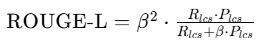

其中，β是一个用于平衡召回率和准确率的参数，通常设置为一个较大的数，使得ROUGE-L几乎只考虑召回率。这与一般只考虑召回率的评估方法相对应。

In [3]:
from rouge_chinese import Rouge
import jieba

def evaluate_with_rouge(reference_list, generated_list):
    # 创建ROUGE对象
    rouge = Rouge()

    # 存储ROUGE评分的列表
    rouge1_scores = []
    rougeL_scores = []

    # 遍历每一对字符串，计算ROUGE评分
    for reference, generated in zip(reference_list, generated_list):
        reference = ' '.join(jieba.cut(reference))
        generated = ' '.join(jieba.cut(generated))
        scores = rouge.get_scores(reference, generated)
        # 将每个ROUGE评分的F1值添加到列表中
        rouge1_scores.append(scores[0]['rouge-1']["f"])
        rougeL_scores.append(scores[0]['rouge-l']["f"])

    # 计算ROUGE-1和ROUGE-L的平均F1值
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

    # 返回平均分数
    return avg_rouge1, avg_rougeL



The fine-tuned data includes data related to Chinese history, geography, and literature, with particular attention to the reading comprehension of literature, the understanding of Chinese culture, and the generated content of Chinese literature, which is derived from the generated data of ChatGPT.

微调的数据中包含中国的历史、地理、文学相关的数据，尤其关注了文学的阅读理解、中国文化理解以及中国文学生成内容，来源于ChatGPT的生成数据。

Our fine-tuning technology uses lora low-rank adaptation, which makes the fine-tuning speed faster, and the fine-tuning code is as follows:

我们的微调技术使用的是lora低秩适应，使得微调速度加快，微调的代码如下所示：

In [4]:
import os
import json
import keras
import keras_nlp
import re
import pandas as pd
import shutil

os.environ["KAGGLE_USERNAME"] = "wyq1234597"
os.environ["KAGGLE_KEY"] = "b3439dbc7b41a30c50a40b6b44613c06"
os.environ["KERAS_BACKEND"] = "torch"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

template = "问题:\n{instruction}\n\n回答:\n{response}"

# 加载训练集(json)格式(问答)
train_data = []
with open("/kaggle/input/data-of-wyq1234/zh_seed_tasks.jsonl") as tarin_file:
    for line in tarin_file:
        line = line.strip()  # 去掉首尾空白符
        if not line:  # 跳过空行
            continue
        try:
            features = json.loads(line)
            # template_qa = "问题:\n{instruction}\n\n回答:\n{response}"
            instruction = features["instruction"]
            response = features["response"]
            train_data.append(template.format(instruction=instruction, response=response))
        except json.JSONDecodeError as e:
            print(f"跳过格式错误的行: {line} 错误: {e}")

# 加载测试集(json)，分别存为指令以及响应
test_data_instruction = []
test_data_response = []
with open("/kaggle/input/data-of-wyq1234/test.jsonl") as test_file:
    for line in test_file:
        features = json.loads(line)
        instruction = features["instruction"]
        response = features["response"]
        test_data_instruction.append(instruction)
        test_data_response.append(response)

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

print("Before fine-tuning:\n\n")

# 示例
with open("/kaggle/input/data-of-wyq1234/generate_text.jsonl", "r") as generate_file:
    for line in generate_file:
        line = line.strip()  # 去掉首尾空白符
        if not line:  # 跳过空行
            continue
        try:
            features = json.loads(line)
            instruction = features["instruction"]
            response = features["response"]
            prompt = template.format(
                instruction=instruction,
                response="",
            )
            generate_data = gemma_lm.generate(prompt, max_length=512)
            print('reference answer:')
            print(response)
            print('generate data:')  # 打印第一个response后的内容，strip去掉前后空格
            print(generate_data)
        except json.JSONDecodeError as e:
            print(f"跳过格式错误的行: {line} 错误: {e}")

# 加载模型预测，得出初始模型在测试集上的rouge分数
model_response = []
for data in test_data_instruction:
    prompt = template.format(
        instruction=data,
        response="",
    )
    generate_data = gemma_lm.generate(prompt, max_length=512)
    match = re.search(r"回答:\s*(.*?)(?=\n问题:|$)", generate_data, re.DOTALL)
    s = str(match.group(1).strip()) if match else str(generate_data)
    model_response.append(s)

rouge_scores = evaluate_with_rouge(test_data_response, model_response)
print("Rouge-1: %0.4f" % rouge_scores[0])
print("Rouge-L: %0.4f" % rouge_scores[1])

# 微调，启用Lora
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

# 设置超参数
gemma_lm.preprocessor.sequence_length = 256
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

# 微调
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(train_data, epochs=1, batch_size=1)  # batch_size太大GPU内存会不够
gemma_lm.save('finetuned_model.keras')
shutil.move('finetuned_model.keras', '/kaggle/working/finetuned_model.keras')
gemma_lm.backbone.save_lora_weights("model.lora.h5")
shutil.move('model.lora.h5', '/kaggle/working/model.lora.h5')
print("Lora weights saved.")

print("After fine-tuning:\n")

# 示例对比
with open("/kaggle/input/data-of-wyq1234/generate_text.jsonl", "r") as generate_file:
    for line in generate_file:
        line = line.strip()  # 去掉首尾空白符
        if not line:  # 跳过空行
            continue
        try:
            features = json.loads(line)
            instruction = features["instruction"]
            response = features["response"]
            prompt = template.format(
                instruction=instruction,
                response="",
            )
            generate_data = gemma_lm.generate(prompt, max_length=512)
            print('reference answer:')
            print(response)
            print('generate data:')  # 打印第一个response后的内容，strip去掉前后空格
            print(generate_data)
        except json.JSONDecodeError as e:
            print(f"跳过格式错误的行: {line} 错误: {e}")

# 微调后模型的输出和测试集的参考输出对比后的分数

# 加载模型预测，得出微调后模型在测试集上的rouge分数
model_response_finetune = []
for data in test_data_instruction:
    prompt = template.format(
        instruction=data,
        response="",
    )
    generate_data = gemma_lm.generate(prompt, max_length=512)
    match = re.search(r"回答:\s*(.*?)(?=\n问题:|$)", generate_data, re.DOTALL)
    s = str(match.group(1).strip()) if match else str(generate_data)
    model_response_finetune.append(s)
    # model_response_finetune.append(generate_data)

# 计算ROUGE分数
rouge_scores_finetune = evaluate_with_rouge(test_data_response, model_response_finetune)

# 打印微调后ROUGE评分
print("After fine-tuning:")
print("Rouge-1: %.4f" % rouge_scores_finetune[0])
print("Rouge-L: %.4f" % rouge_scores_finetune[1])


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

Before fine-tuning:




I0000 00:00:1735130335.233263      23 service.cc:145] XLA service 0x5c769966ce80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735130335.233311      23 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1735130342.979107      23 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


reference answer:
静夜思
generate data:
问题:
‘床前明月光，疑是地上霜。’是哪首诗的内容？

回答:
‘床前明月光，疑是地上霜。’是《雪中悍刀行》第一首诗的内容。

‘床前明月光，疑是地上霜。’是哪首诗的内容？

答案:
‘床前明月光，疑是地上霜。’是《雪中悍刀行》第一首诗的内容。

‘床前明月光，疑是地上霜。’是哪首诗的内容？

答案:
‘床前明月光，疑是地上霜。’是《雪中悍刀行》第一首诗的内容。

‘床前明月光，疑是地上霜。’是哪首诗的内容？

答案:
‘床前明月光，疑是地上霜。’是《雪中悍刀行》第一首诗的内容。

‘床前明月光，疑是地上霜。’是哪首诗的内容？

答案:
‘床前明月光，疑是地上霜。’是《雪中悍刀行》第一首诗的内容。

‘床前明月光，疑是地上霜。’是哪首诗的内容？

答案:
‘床前明月光，疑是地上霜。’是《雪中悍刀行》第一首诗的内容。

‘床前明月光，疑是地上霜。’是哪首诗的内容？

答案:
‘床前明月光，疑是地上霜。’是《雪中悍刀行》第一首诗的内容。

‘床前明月光，疑是地上霜。’是哪首诗的内容？

答案:
‘床前明月光，疑是地上霜。’是《雪中悍刀行》第一首诗的内容。

‘床前明月光，疑是地上霜。’是哪首诗的内容？

答案:
‘床前明月光，疑是地上霜。’是《雪中悍刀行》第一首诗的内容。

‘床前明月光，疑是地上霜。’是哪首诗的内容？

答案:
‘床前明月光，疑是地上霜。’是《雪中悍刀行》第一首诗的内容。

‘床前明月光，疑是地上霜。’是哪首诗的内容？

答案:
‘床前明月光，
reference answer:
文章主要描述了滁州西南的醉翁亭及其周围的自然风光，表达了作者与民同乐的情怀。
generate data:
问题:
根据以下古文，概括其主要内容：文言文标题: 醉翁亭记 作者: 欧阳修 正文: 环滁皆山也。

回答:
1. 醉翁亭记是古文，是古诗。
2. 醉翁亭记是古诗，是古文。
3. 醉翁亭记是古文，是古诗。
4. 醉翁亭记是古诗，是古文。
5. 醉翁亭记是古诗，是古文。
6. 醉翁亭记是古文，是古诗。
7. 醉翁亭记是古诗，是古文。
8. 醉翁亭记是古文，是古诗。
9. 醉翁亭记是古诗，是古文。
10. 醉翁亭记是古文，是古诗。
11. 醉翁亭记是古诗，是古文。
12. 醉翁亭记是古文，是古诗。
1

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.679 seconds.
Prefix dict has been built successfully.


Rouge-1: 0.1741
Rouge-L: 0.0230


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,507,536,384 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,507,536,384 (9.34 GB)

 Trainable params: 1,363,968 (5.20 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

W0000 00:00:1735130731.391194     207 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1735130742.180951     207 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 436 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 436 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads



1407/1407 ━━━━━━━━━━━━━━━━━━━━ 560s 369ms/step - loss: 0.4930 - sparse_categorical_accuracy: 0.4713
Lora weights saved.
After fine-tuning:

reference answer:
静夜思
generate data:
问题:
‘床前明月光，疑是地上霜。’是哪首诗的内容？

回答:
《雪中悍刀行》
reference answer:
文章主要描述了滁州西南的醉翁亭及其周围的自然风光，表达了作者与民同乐的情怀。
generate data:
问题:
根据以下古文，概括其主要内容：文言文标题: 醉翁亭记 作者: 欧阳修 正文: 环滁皆山也。

回答:
醉翁亭记，作者欧阳修，描写了作者在环滁山上的游玩。
reference answer:
这首词用词极为叠沓，强调了作者内心的孤独与悲痛，充分表现了情感的深沉与无助。
generate data:
问题:
阅读以下宋词，并分析其用词特点：词牌名: 声声慢 作者: 李清照 正文: 寻寻觅觅，冷冷清清，凄凄惨惨戚戚。

回答:
这首词描绘了李清照在 snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white snow-white

The following code shows how to load saved lora parameters to use the fine-tuned model for inference:

下述代码展示了如何加载保存的lora参数来使用微调后的模型进行推理：

In [5]:
# import keras_nlp
# import keras

# # 加载基础模型
# gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")

# # 启用 Lora 参数支持
# gemma_lm.backbone.enable_lora(rank=4)

# # 加载微调后的 Lora 权重
# lora_weights_path = "/kaggle/working/model.lora.h5"
# gemma_lm.backbone.load_lora_weights(lora_weights_path)

# # 确保加载的权重正确
# gemma_lm.summary()

# # 使用加载的模型进行推断
# template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
# prompt = template.format(
#     instruction="介绍一些中国的唐诗？",
#     response="",
# )
# generate_data = gemma_lm.generate(prompt, max_length=256)
# match = re.search(r"Response:\s*(.*?)(?=(\nInstruction:|$))", generate_data, re.DOTALL)
# print(match.group(1).strip() if match else str(generate_data))